In [70]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import imread
import os

In [71]:
%matplotlib inline

### Group 5 

* Zhong Chen

* Yeting Dong

* Yunis Fanger

* Alexander Jesipow

* Yinan Shi

# Assignment 2:
## Task1:

* $\textbf{Question one}$:

With $\sigma_{1,1}^2 \geq ... \geq  \sigma_{p,p}^2 \geq  0$, $\mathbf{s}=[s_1,s_2,...,s_p]^\intercal$ and $\sum^p_{i=1} s_{i}^2=1$ 
given that $s_{i}^2 \geq 0$ holds,

the term $\mathbf{s}^\intercal \Sigma \Sigma^\intercal \mathbf{s}=\sum^p_{i=1} \sigma_{i,i}^2 s_{i}^2$ is maximized by 
$\mathbf{\hat{s}}=[\hat{s}_{1}^2=1,\hat{s}_{2}^2=0,...,\hat{s}_{p}^2=0]^\intercal$ .

Proof: $ \sum^p_{i=1} \sigma_{i,i}^2 s_i^2  \leq \sum^p_{i=1} \sigma_{1,1}^2 s_i^2  
= \sigma_{1,1}^2 \sum^p_{i=1} s_i^2 = \sigma_{1,1}^2$

Therefore the two maximizing vectors are 
$\mathbf{\hat{s}}= [\hat{s}_{1} = \pm 1,\hat{s}_{2}=0,...,\hat{s}_{p}=0]^\intercal$.

* $\textbf{Question two}$:

The objective is to find $\mathbf{a}$ that maximizes 
$\frac{1}{N} \mathbf{a}^\intercal \mathbf{X} \mathbf{X}^\intercal \mathbf{a} = 
\frac{1}{N} \mathbf{a}^\intercal \mathbf{U} \mathbf{\Sigma}  \mathbf{V}^\intercal  \mathbf{V} \mathbf{\Sigma}^\intercal \mathbf{U}^\intercal \mathbf{a} = \frac{1}{N} \mathbf{a}^\intercal \mathbf{U} \mathbf{\Sigma} \mathbf{\Sigma}^\intercal \mathbf{U}^\intercal \mathbf{a}$.

From question one we know, that one of the vectors $\mathbf{U}^\intercal \mathbf{a}$ maximizing this is $\mathbf{U}^\intercal \mathbf{a} = \mathbf{\hat{s}}= [1,0,...,0]^\intercal$. 

Therefore $\mathbf{a} \mathbf{u}_i= 
\begin{cases}
    1, & \text{if } i=1 \\
    0, & \text{otherwise}
\end{cases} $, 
with $\mathbf{U}=[\mathbf{u}_1,\mathbf{u}_2,...,\mathbf{u}_p]$ must hold. 

Since $\mathbf{U}$ is a orthonormal matrix 
the  scalarproduct  $\mathbf{u_1}\mathbf{u_1}=1 $ and since all other coloums are perpendicular to the first the scalarproduct  $\mathbf{u_1}\mathbf{u_i}=0$ for $i > 1$. Thus by choosing $\mathbf{a} = \mathbf{u}_1$ the term is maximized while still guaranteeing $\lVert \mathbf{a} \rVert=1$. 


## Task2:

In [72]:


def compute_singlular_vectors(T,num_vectors=20):
    
    T_mu=np.mean(T,axis=1)
    T_centered=T-np.expand_dims(T_mu,axis=1)
    
    u,s,v = np.linalg.svd(T_centered)
    #u,s,v = scipy_svd(Sig,k=num_vectors)
    return u[:,:num_vectors]

def load_images_form_path(path):
    list_of_images_in_path = os.listdir(path)
    T = np.zeros((50 ** 2, len(list_of_images_in_path)))
    T_labels = [0] * len(list_of_images_in_path)
    for i_image, image_name in enumerate(list_of_images_in_path):
        T[:, i_image] = imread(path + '/' + image_name).flatten()
        T_labels[i_image] = int(image_name[6:8])
    return T, T_labels


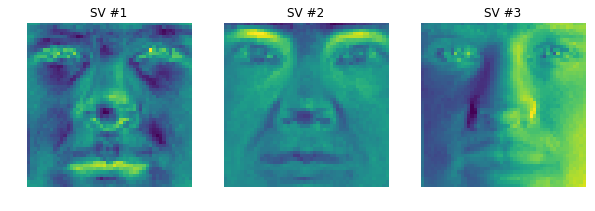

In [73]:
path_to_training_data = './yaleBfaces/subset0'

T, T_labels = load_images_form_path(path_to_training_data)

u_max_sv = compute_singlular_vectors(T)


plt.figure(figsize=(10, 10))
for i_vec, axis in enumerate(('131', '132', '133')):
    plt.subplot(axis)
    plt.axis('off')
    plt.title('SV #{}'.format(i_vec + 1))
    u_vec = u_max_sv[:, i_vec]
    u_vec_image = u_vec.reshape(50, -1)
    plt.imshow(u_vec_image)

plt.show()


In [74]:
def find_knn(sample, data, k):
    distances_to_neigbors = np.linalg.norm(data - np.expand_dims(sample, axis=1), axis=0)
    aggregated_distances = np.argpartition(distances_to_neigbors, k)
    aggregated_distances = np.argsort(distances_to_neigbors)
    aggregated_distances_sorted = aggregated_distances[:k]
    i_knn = aggregated_distances_sorted
    knn_values = distances_to_neigbors[i_knn]


    return i_knn, knn_values

def select_winner_class(knn_labels):
    fre=np.zeros((1,3))
    for j in range(3):
            fre[0,j]=knn_labels.count(knn_labels[j])
    winner=knn_labels[np.argmax(fre)]

    return winner

def classify_image_3nn(T, labels, S, PC, k):
    T_mu = np.mean(T, axis=1)
    T_centered = T - np.expand_dims(T_mu, axis=1)

    S_centered = S - np.expand_dims(T_mu, axis=1)

    P = PC[:, :k].T
    T_dimensionality_reduced = P.dot(T_centered)
    S_dimensionality_reduced = P.dot(S_centered)
    classification_labels = np.zeros((S.shape[1],))

    for i_sample in range(S.shape[1]):
        sample_image = S_dimensionality_reduced[:, i_sample]
        i_knn, _ = find_knn(sample_image, T_dimensionality_reduced, k=3)
        winner_labels = [labels[i_n] for i_n in i_knn]
        winner_class = select_winner_class(winner_labels)
        classification_labels[i_sample] = winner_class

    return classification_labels


def compute_error_rate_pca(T, T_labels, S, S_labels, PC, k):
    classification_labels = classify_image_3nn(T, T_labels, S, PC, k)

    correct_classification_rate = np.sum(classification_labels == S_labels) / S.shape[1]

    return 1 - correct_classification_rate


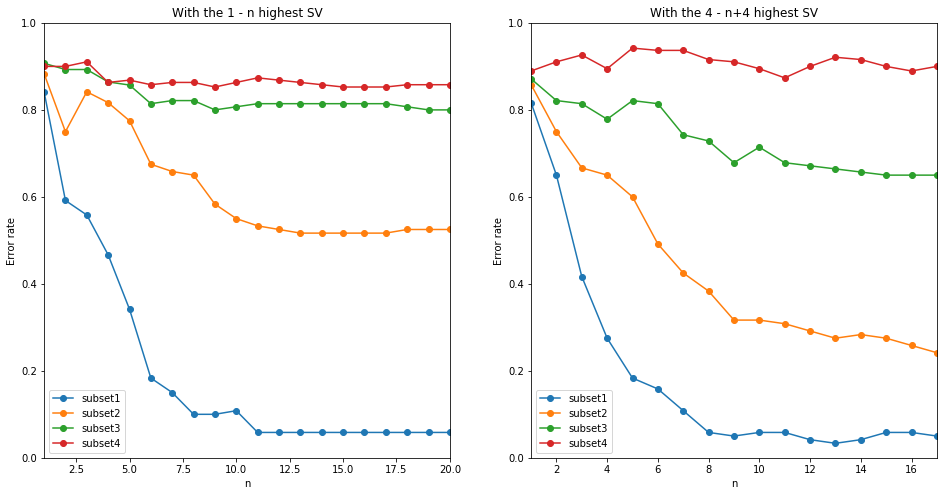

In [77]:
S = {}
S_labels = {}
i_val_subsets = range(1, 5)
error_rates = np.zeros((4, 20))
error_rates_without_3_sv = np.zeros((4, 17))

for i_subset in i_val_subsets:
    path_subset = './yaleBfaces/subset{}'.format(i_subset)
    subset_key_for_dic = 'subset{}'.format(i_subset)
    S[subset_key_for_dic], S_labels[subset_key_for_dic] = load_images_form_path(path_subset)

    for num_of_sv in range(1, 21):
        error_rate = compute_error_rate_pca(T, T_labels, S[subset_key_for_dic], S_labels[subset_key_for_dic], u_max_sv,
                                            num_of_sv)
        error_rates[i_subset - 1, num_of_sv - 1] = error_rate

    for num_of_sv in range(1, 18):
        error_rate = compute_error_rate_pca(T, T_labels, S[subset_key_for_dic], S_labels[subset_key_for_dic],
                                            u_max_sv[:, 3:], num_of_sv)
        error_rates_without_3_sv[i_subset - 1, num_of_sv - 1] = error_rate

x_vals = np.repeat(np.arange(1, 21).reshape(1, 20), 4, axis=0)
x_vals_without_3_sv = np.repeat(np.arange(1, 18).reshape(1, 17), 4, axis=0)

subset_labels = ['subset{}'.format(i_subset) for i_subset in i_val_subsets]

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('With the 1 - n highest SV')
for i in range(4):
    plt.plot(x_vals[i, :], error_rates[i, :], linestyle='-', marker='o')

plt.ylabel('Error rate')
plt.ylim(0, 1)
plt.xlabel('n')
plt.xlim(1, 20)
plt.legend(subset_labels)

plt.subplot(122)
plt.title('With the 4 - n+4 highest SV')
for i in range(4):
    plt.plot(x_vals_without_3_sv[i, :], error_rates_without_3_sv[i, :], linestyle='-', marker='o')

plt.ylabel('Error rate')
plt.ylim(0, 1)
plt.xlabel('n')
plt.xlim(1, 17)
plt.legend(subset_labels)
plt.show()



* The improvement in recognition rate stems from the fact, that the first few singular vectors primarily contain
information about the external conditions,which are found specifically in the training subset, such as the illumination. This information is however not helpful in identifying faces under the altered conditions in the other subsets and thus the error rate is actually higher when incorperating these singular vectors in dimensionality reducing projection matrix. 